In [28]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm

In [29]:
def mean_absolute_percentage_error(y_true, y_pred):
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

def mape_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return mean_absolute_percentage_error(y, y_pred)

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [3]:
file_path = r"G:\Meu Drive\MESTRADO - MLOG\Projeto EV-Explore Ambev\TESTE_MAP_MATCHING_25_04\DATA_30_08_2024.xlsx"
data = pd.read_excel(file_path)

In [4]:
data

,ID_Rota,Energy_Estimated(%),Distance_Traveled(km),Avg_Temperature(C),Air_Humidity(%),Dist_Cluster_Clients(km),Route_Time(h),Total_Weighted_Mass(ton),Stdv_Altitudes(m),Wind_Speed(m/s),Avg_Speed(m/s),Number_Deliveries,Rain(mm),Max_Temp(C),Real_Energy_Expenditure(%)
0,20230901_RHQ2H04,41.716498,40.4,22.144429,52.796897,14.067360,3.185833,8.094501,7.352432,1.495487,3.524209,10,0.000000,27.5,41.2
1,20230902_RHS6B08,47.357887,49.6,22.191493,67.361194,7.806090,2.211111,9.206331,8.139739,2.044776,6.244209,8,0.000000,29.6,41.6
2,20230902_RHS6F90,54.828160,50.1,23.431280,62.676540,15.033330,3.123611,8.473027,20.839832,2.096801,4.455477,13,0.000000,29.6,46.4
3,20230902_RHT4G96,45.270473,54.3,19.594087,76.893316,19.882506,3.283333,7.848595,10.572484,1.692545,4.597407,9,0.000000,24.0,38.0
4,20230904_RHQ2H05,70.687503,57.8,27.653575,51.407254,18.174622,3.598056,9.276940,21.626044,3.153472,4.485942,11,0.000000,30.9,52.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,20240215_RHS6B06,44.577909,41.9,20.597115,88.774038,1.555601,2.258611,9.974098,16.337546,2.152644,5.198889,8,0.083173,22.3,36.8
173,20240220_RHS6F91,44.204194,51.8,21.943542,83.979167,12.778484,2.440278,9.663950,7.199588,1.208125,5.905980,14,0.120833,23.8,37.2
174,20240222_RHQ2H03,51.895367,58.9,24.058857,73.000000,11.092253,2.813611,8.282822,23.873651,1.963810,5.817566,12,0.000000,29.0,53.2
175,20240226_RHS6F92,59.709741,54.6,23.718381,75.708263,8.025749,3.442500,10.503930,8.306538,1.892749,4.403178,8,0.000000,26.5,44.4


In [5]:
X = data[['Energy_Estimated(%)', 'Distance_Traveled(km)']]
y = data['Real_Energy_Expenditure(%)']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
model = RandomForestRegressor(random_state=42)

In [8]:
param_grid = {
    'n_estimators': [50, 75, 100, 125, 150, 175, 200],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8],
    'max_features': [0.1, 0.15, 0.2, 0.25, 0.5], 
    'bootstrap': [True]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=mape_scorer, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print("Melhores Hiperparâmetros:", grid_search.best_params_)

Fitting 5 folds for each of 4900 candidates, totalling 24500 fits
Melhores Hiperparâmetros: {'bootstrap': True, 'max_depth': None, 'max_features': 0.1, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}


In [10]:
best_model = grid_search.best_estimator_

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_val_score(best_model, X, y, cv=kf, scoring=mape_scorer)

print(f'MAPE por Fold (validação cruzada): {-cv_results}')
print(f'Média do MAPE (validação cruzada): {-cv_results.mean()}')
print(f'Desvio padrão do MAPE (validação cruzada): {cv_results.std()}')

MAPE por Fold (validação cruzada): [ 7.13299915  9.40906733  8.23092125 10.24848609  9.30329193]
Média do MAPE (validação cruzada): 8.864953149005235
Desvio padrão do MAPE (validação cruzada): 1.077406667559428


In [11]:
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f'MAPE no conjunto de teste: {test_mape:.2f}%')
print(f'R² no conjunto de teste: {test_r2:.2f}')

MAPE no conjunto de teste: 7.35%
R² no conjunto de teste: 0.76


In [12]:
import joblib

joblib.dump(best_model, 'best_model_random_forest.pkl')

['best_model_random_forest.pkl']

                 Feature  Importance
0    Energy_Estimated(%)    0.578721
1  Distance_Traveled(km)    0.421279


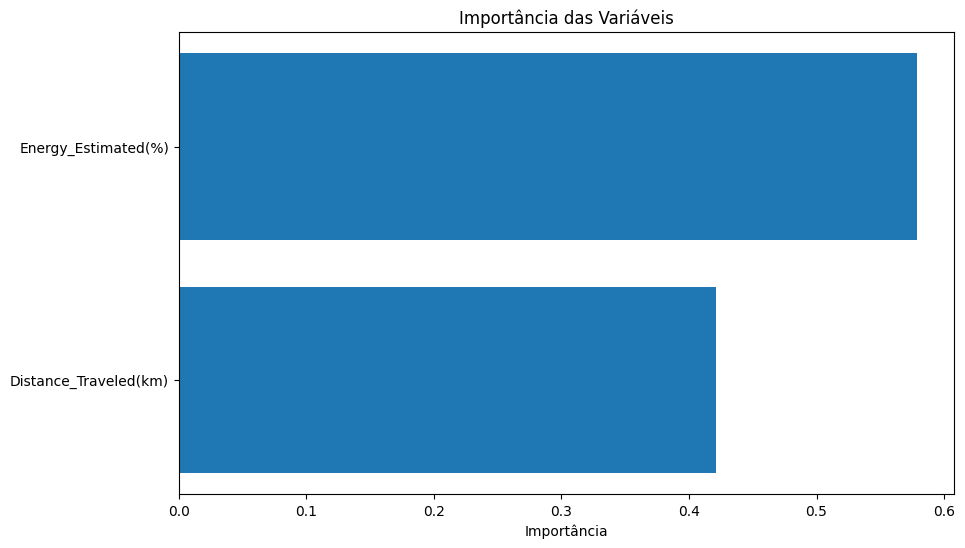

In [13]:
importances = best_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importância')
plt.title('Importância das Variáveis')
plt.gca().invert_yaxis()
plt.show()

In [14]:
residuos = [y_t - y_p for y_t, y_p in zip(y_test, y_pred)]

residuos = np.array(residuos, dtype=np.float64)

residuos = pd.Series(residuos)

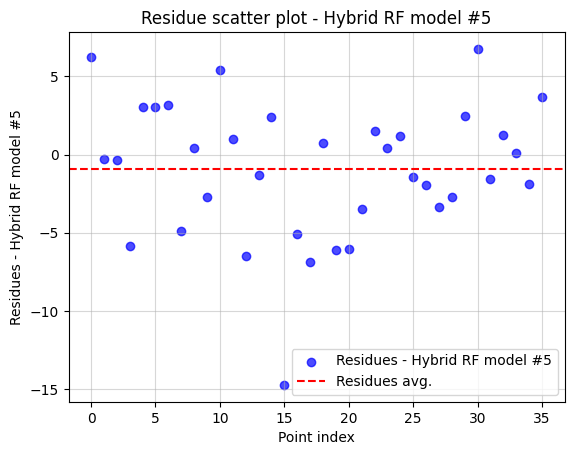

In [15]:
media_residuos = np.mean(residuos)

plt.scatter(range(len(residuos)), residuos, color='blue', alpha=0.7, label='Residues - Hybrid RF model #5')
plt.axhline(y=media_residuos, color='red', linestyle='--', label='Residues avg.')
plt.xlabel('Point index')
plt.ylabel('Residues - Hybrid RF model #5')
plt.title('Residue scatter plot - Hybrid RF model #5')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.5)

plt.savefig('scatter_plot_RF.png', dpi=300, bbox_inches='tight')

plt.show()

In [16]:
mean = np.mean(residuos)
std = np.std(residuos)

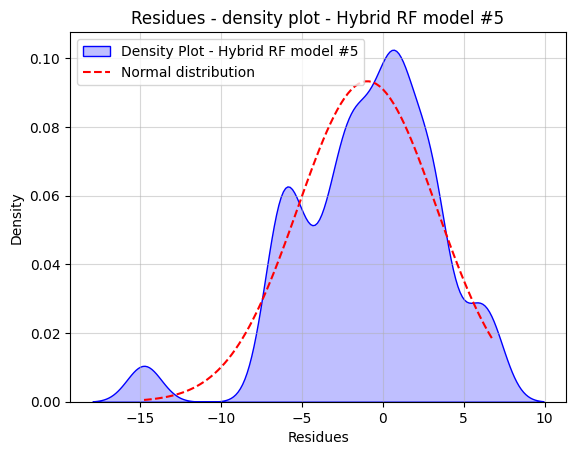

In [17]:
# Plotar a densidade dos resíduos
sns.kdeplot(residuos, fill=True, color='blue', label='Density Plot - Hybrid RF model #5', bw_adjust=0.5)

# Criar os valores de x para a curva de distribuição normal
x_values = np.linspace(min(residuos), max(residuos), 100)

# Plotar a curva de distribuição normal usando a média e o desvio padrão dos resíduos
plt.plot(x_values, norm.pdf(x_values, mean, std), color='red', linestyle='dashed', label='Normal distribution')

# Configurações do gráfico
plt.title('Residues - density plot - Hybrid RF model #5')
plt.xlabel('Residues')
plt.ylabel('Density')

# Exibir legenda e grade
plt.legend(loc='upper left')
plt.grid(True, alpha=0.5)

# Salvar o gráfico como imagem
plt.savefig('density_plot_RF.png', dpi=300, bbox_inches='tight')

# Exibir o gráfico
plt.show()

In [18]:
shapiro_test = stats.shapiro(residuos)
print("Estatística de teste:", shapiro_test[0])
print("Valor-p:", shapiro_test[1])

Estatística de teste: 0.9575014710426331
Valor-p: 0.17983274161815643


In [20]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

X_test_v2 = sm.add_constant(X_test)

# Realiza o teste de Breusch-Pagan/Cook-Weisberg
lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(residuos, X_test_v2)

# Imprime os resultados
print("Estatística LM:", lm)
print("Valor-p LM:", lm_p_value)
print("Estatística F:", fvalue)
print("Valor-p F:", f_p_value)

Estatística LM: 2.0765158317720678
Valor-p LM: 0.3540709663990328
Estatística F: 1.0099938748723425
Valor-p F: 0.37520289082134256


In [21]:
from scipy.stats import norm

# Calcula o teste de Durbin-Watson
durbin_watson_test = sm.stats.stattools.durbin_watson(residuos)

# Imprime o resultado
print("Estatística de Durbin-Watson:", durbin_watson_test)

nobs = len(residuos)
nvars = 2

# Calculando o valor crítico DW
d_critico = sm.stats.stattools.durbin_watson(residuos)

# Calculando DL, DU, 4-DL e 4-DU
DL = 1.521 - 1.25 * (nvars / nobs)
DU = 1.521 + 1.25 * (nvars / nobs)
quatro_DL = 4.0 - DL
quatro_DU = 4.0 - DU

# Imprimindo os resultados
print("DL:", DL)
print("DU:", DU)
print("4-DL:", quatro_DL)
print("4-DU:", quatro_DU)

Estatística de Durbin-Watson: 1.6434236418461923
DL: 1.4515555555555555
DU: 1.5904444444444443
4-DL: 2.5484444444444447
4-DU: 2.4095555555555555


In [23]:
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 7.35%


In [24]:
n = X_test.shape[0]
k = X_test.shape[1]

In [25]:
y_test_mean = np.mean(y_test)

# Calcular SSR (Sum of Squares Regression)
SSR = np.sum((y_pred - y_test_mean) ** 2)

# Calcular SSE (Sum of Squares Error)
SSE = np.sum((y_test - y_pred) ** 2)

# Calcular SST (Sum of Squares Total)
SST = np.sum((y_test - y_test_mean) ** 2)

# Calcular MSR (Mean Square Regression)
MSR = SSR / k

# Calcular MSE (Mean Square Error)
MSE = SSE / (n - k - 1)

# Calcular a estatística F
F_statistic = MSR / MSE

# Exibir os resultados
print(f'SSR (Sum of Squares Regression): {SSR}')
print(f'SSE (Sum of Squares Error): {SSE}')
print(f'MSR (Mean Square Regression): {MSR}')
print(f'MSE (Mean Square Error): {MSE}')
print(f'Estatística F: {F_statistic}')

SSR (Sum of Squares Regression): 2122.907087523315
SSE (Sum of Squares Error): 691.1632678407736
MSR (Mean Square Regression): 1061.4535437616576
MSE (Mean Square Error): 20.94434144972041
Estatística F: 50.679728761575696


In [26]:
from scipy.stats import f

df1 = k  
df2 = n - k - 1  

# Calcular o p-valor da estatística F
p_value = f.sf(F_statistic, df1, df2)

print(f'Prob (F-statistic): {p_value}')

Prob (F-statistic): 8.690685218378387e-11


In [27]:
y_pred

array([52.1435197 , 37.91347632, 35.12213766, 55.07027015, 62.94269841,
       50.94062606, 37.64252856, 42.08478326, 36.37509282, 47.91357565,
       60.21983565, 45.40631775, 42.51482129, 54.92724071, 36.77533347,
       53.93286647, 46.65535786, 56.06817065, 56.45329475, 48.08027188,
       50.86724129, 39.88765634, 46.47431431, 44.38467339, 46.78394712,
       41.00619125, 41.52768187, 47.33210043, 53.89123443, 43.51452794,
       59.6415687 , 38.34434936, 46.36572423, 60.6874547 , 39.50798723,
       52.32069792])

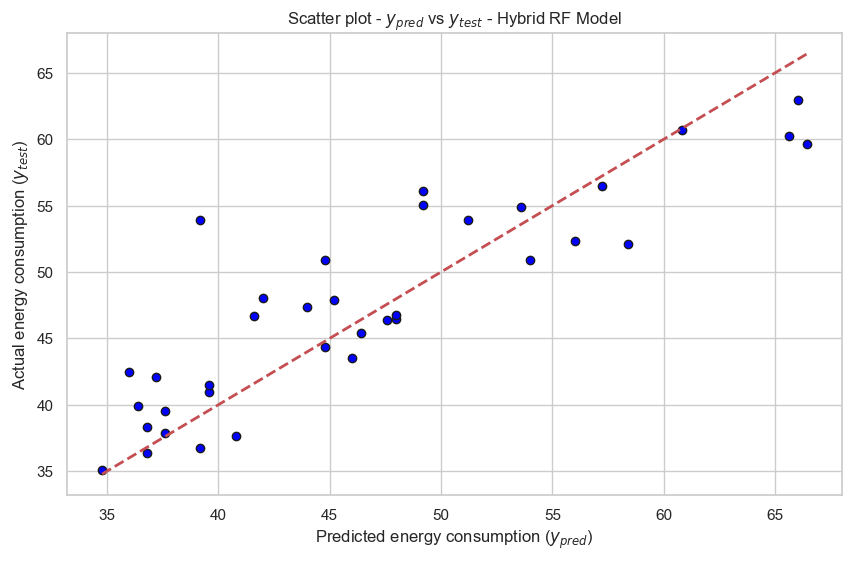

In [33]:
sns.set(style="whitegrid")

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel('Predicted energy consumption ($y_{pred}$)')
plt.ylabel('Actual energy consumption ($y_{test}$)')
plt.title('Scatter plot - $y_{pred}$ vs $y_{test}$ - Hybrid RF Model')

plt.savefig('pred_RF.png', dpi=300, bbox_inches='tight')

plt.show()